# Brewster angle incidence

In [3]:
import os
os.chdir('../../../')
from rwp.environment import *
from rwp.sspade import *
from rwp.tworay import *
from rwp.vis import *

Preparing environment

In [4]:
environment = Troposphere(flat=True)
environment.z_max = 100
environment.ground_material = CustomMaterial(eps=3, sigma=0)

Preparing transmitting antenna

In [5]:
freq_hz = 3000e6
b_angle = brewster_angle(1, environment.ground_material.complex_permittivity(freq_hz)).real
antenna = GaussAntenna(freq_hz=freq_hz, height=50, beam_width=5, eval_angle=90-b_angle, polarz='V')
h1 = antenna.height_m
h2 = 0
a = abs((h1 - h2) / cm.tan(abs(antenna.eval_angle) * cm.pi / 180))
max_range = 2 * a + 200

Specifying computational parameters of the finite-difference Pade propagator

In [6]:
pade_params = HelmholtzPropagatorComputationalParams(two_way=False,
                                                     exp_pade_order=(7, 8),
                                                     max_propagation_angle=abs(antenna.beam_width) + abs(antenna.eval_angle) + 5,
                                                     z_order=5,
                                                     dx_wl=2,
                                                     dz_wl=0.05,
                                                     inv_z_transform_tau=10**(3 / (max_range / antenna.wavelength / 2))
                                                     )

Calculating the electromagnetic field

In [7]:
pade_task = TroposphericRadioWaveSSPadePropagator(antenna=antenna, env=environment, max_range_m=max_range, comp_params=pade_params)
pade_field = pade_task.calculate()

Generating reference solution by the two-ray model

In [8]:
trm = TwoRayModel(src=antenna, env=environment)
x_grid_m = np.linspace(1, max_range, 5000)
z_grid_m = np.linspace(1, environment.z_max, 500)
trm_f = trm.calculate(x_grid_m, z_grid_m)
trm_field = Field(x_grid=x_grid_m, z_grid=z_grid_m, freq_hz=antenna.freq_hz)
trm_field.field[:, :] = trm_f

Visualising results

In [9]:
pade_vis = FieldVisualiser(pade_field, trans_func=lambda v: 10 * cm.log10(1e-16 + abs(v)), label='Pade + nonlocal BC', x_mult=1)
trm_vis = FieldVisualiser(trm_field, trans_func=lambda v: 10 * cm.log10(1e-16 + abs(v))-7, label='Two-ray model')

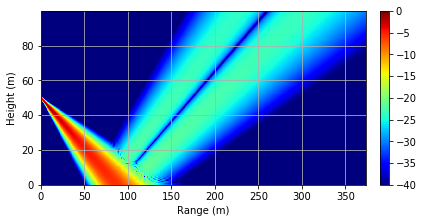

In [10]:
plt = pade_vis.plot2d(min=-40, max=0)
plt.xlabel('Range (m)')
plt.ylabel('Height (m)')
plt.tight_layout()
plt.grid(True)
plt.show()

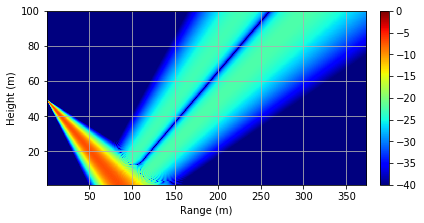

In [11]:
plt = trm_vis.plot2d(min=-40, max=0)
plt.xlabel('Range (m)')
plt.ylabel('Height (m)')
plt.grid(True)
plt.tight_layout()
plt.show()

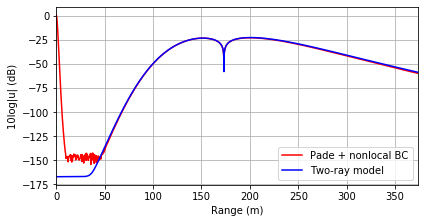

In [12]:
plt = pade_vis.plot_hor(50, trm_vis)
plt.xlabel('Range (m)')
plt.ylabel('10log|u| (dB)')
plt.tight_layout()
plt.grid(True)
plt.show()